In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import torch
from torch.nn import Module, Sequential, Linear, ReLU, Tanh, Sigmoid
import torch.nn.functional as F
from tukey import losses
from tukey.transforms import SoftPlusTransform

## Definition of neural network 

For this simulated data experiments, we use a simple neural network with a few dense layers. Note that the transformations that ensure that the outputs of the neural network are in the correct domain (i.e. positive for $\sigma$ and $h$ are in the loss class, not directly in the neural network.

In [2]:
class NN(Sequential):
    def __init__(self, structure: list, n_out: int):
        subblocks = []
        self.n_out = n_out
        for i in range(len(structure) - 1):
            subblocks.extend(self._make_sublock(structure[i], structure[i + 1]))
        subblocks.extend(self._make_final_layer(structure[-1]))
        super().__init__(*subblocks)

    def _make_sublock(self, n_in: int, n_out: int):
        return [Linear(n_in, n_out), ReLU(), ]

    def _make_final_layer(self, n_in : int):
        return [Linear(n_in, self.n_out), ]

nn = NN((1, 512, 512, 512), 4)  # 4 outputs required for G-and-H
nn_gaussian = NN((1, 512, 512, 512), 2)  # 2 outputs required for Gaussian

## Definition of the true model and simulation 

For our simulation study, we consider a very simple regression problem of a scalar target $Y$ in terms of a scalar feature $X$. The true conditional distribution of $Y$ given $X$ is defined according to the following equation,

\begin{equation}
    Y | X \sim \mu(X) + \sigma(X) \tau_{g(X), h(X)}(Z),
\end{equation}
where the functions $\mu(\cdot)$, $\sigma(\cdot)$, $g(\cdot)$ and $h(\cdot)$ are defined arbitrarily --- see the functioon $f$ defined in the code portion below. The random variable $Z$ is standard normal, $Z\sim\mathcal{N}(0, 1)$, while $\tau_{g,h}$ is the tukey $g$ and $h$ transform.

For our simulations we sample $X$ according to a uniform distribution on the interval $[0, 1]$.

<IPython.core.display.Javascript object>


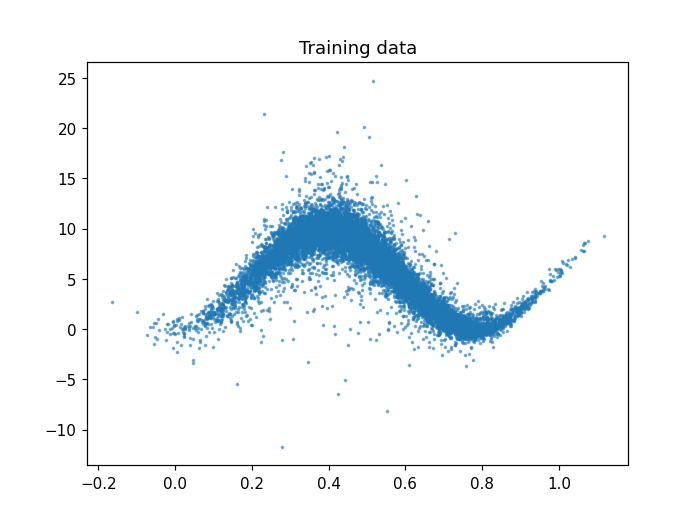

In [3]:
def f(x: float) -> tuple:
    """Function providing the 4 parameters (mu, beta, g, h) of the transformation applied to 
    a standard normal variable given the input x. Chosen arbitrarily for the simulation.
    """
    return 10 * np.sin(4 * x) ** 2, 1 + 3 * (x - 0.25)**2, 1 / 2 * (x - 0.5), np.maximum(0, 0.25 - (x - 0.5)**2)

def tukey_g_h(z: float, theta: tuple):
    """Applies the tukey-g-h transform with parameters theta to z."""
    mu, beta, g, h = theta
    z_tilda = 1 / g * (np.exp(g * z) - 1) * np.exp(h * z**2 / 2)
    return mu + 1 / beta * z_tilda

def t_dist(x: float):
    return t(df = 3 * x + 3, loc = 4 * x**2, scale = 0.2 + (x - 0.5)**2).rvs(10000)


n_samples = 20000
train_split = int(n_samples * 0.8)

x_data = np.random.randn(n_samples).astype(np.float32) / 6 + 0.5
theta = f(x_data)

z = np.random.randn(n_samples).astype(np.float32)
y_data = tukey_g_h(z, theta)

x_data, x_data_val = x_data[:train_split], x_data[train_split:]
y_data, y_data_val = y_data[:train_split], y_data[train_split:]

#y_data = t_dist(x_data)

%matplotlib notebook
import matplotlib as mpl
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x_data, y_data, s=2, alpha=0.5)
_ = ax.set_title('Training data')

## Training 

In [6]:
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset

BATCH_SIZE = 128
N_EPOCHS=25

loss = losses.TuckeyGandHloss(n_target_channels=1)
loss_gaussian = losses.GaussianLoss(n_target_channels=1)
nn_parameters = nn.parameters()
nn_gaussian_parameters = nn_gaussian.parameters()

x_torch, y_torch = torch.tensor(x_data).reshape((-1, 1)), torch.tensor(y_data).reshape((-1, 1))
x_val_torch, y_val_torch = torch.tensor(x_data_val).reshape((-1, 1)), torch.tensor(y_data_val).reshape((-1, 1))

dataset = TensorDataset(x_torch, y_torch)
dataset_val = TensorDataset(x_val_torch, y_val_torch)
optimizer = Adam(nn_parameters, lr=1e-4)
optimizer_gaussian = Adam(nn_gaussian_parameters, lr=1e-4)

In [7]:
def train_for_one_epoch(nn, dataset):
    nn.train()
    nn_gaussian.train()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    losses_gaussian = []
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = nn(x)
        loss_y_yhat = loss(y_hat, y)
        loss_y_yhat.backward()
        optimizer.step()
        losses.append(loss_y_yhat.detach().item())
        # gaussian
        optimizer_gaussian.zero_grad()
        y_hat = nn_gaussian(x)
        loss_y_yhat = loss_gaussian(y_hat, y)
        loss_y_yhat.backward()
        optimizer_gaussian.step()
        losses_gaussian.append(loss_y_yhat.detach().item())
    print('Train losses: ', np.mean(losses), np.mean(losses_gaussian))
    
    nn.eval()
    nn_gaussian.eval()
    dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    losses_gaussian = []
    with torch.no_grad():
        for x, y in dataloader_val:
            y_hat = nn(x)
            loss_y_yhat = loss(y_hat, y)
            losses.append(loss_y_yhat.detach().item())
            y_hat = nn_gaussian(x)
            loss_y_yhat = loss_gaussian(y_hat, y)
            losses_gaussian.append(loss_y_yhat.detach().item())
    print('Validation losses: ', np.mean(losses), np.mean(losses_gaussian))
            



for i_epoch in range(N_EPOCHS):
    epoch_loss = train_for_one_epoch(nn, dataset)

Train losses:  0.5775397205352784 0.7358923661708832
Validation losses:  0.5635602818801999 0.7085326630622149
Train losses:  0.574593276977539 0.7389161739349365
Validation losses:  0.5656493520364165 0.77638765797019
Train losses:  0.5783119943141938 0.7395803925991058
Validation losses:  0.5641629537567496 0.7096053566783667
Train losses:  0.5768308334350586 0.7357132229804992
Validation losses:  0.5665492871776223 0.7114411080256104
Train losses:  0.5780590591430664 0.7382368416786194
Validation losses:  0.5575780449435115 0.70400529820472
Train losses:  0.5766282074451446 0.7398651795387268
Validation losses:  0.5562474559992552 0.7192936018109322


KeyboardInterrupt: 

## Analysis 

For analysis, we plot the 4 functions of $x$ that make up the true model (solid lines) and the values predicted by the neural network (dashed lines).

<IPython.core.display.Javascript object>


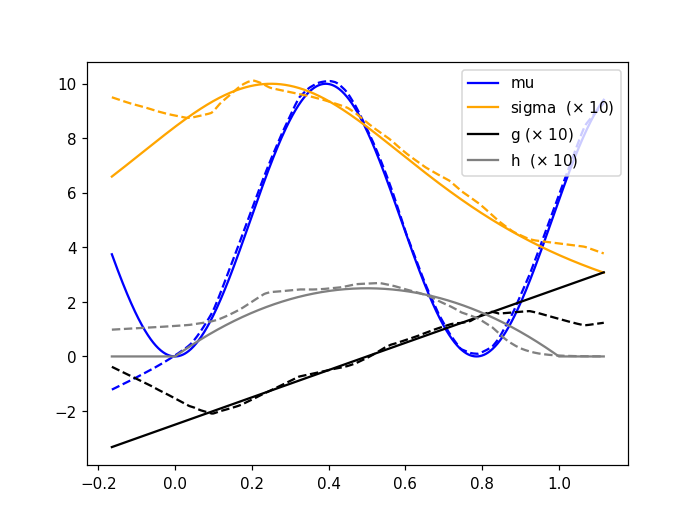

In [8]:
x_plot = np.linspace(min(x_data), max(x_data), 1000).astype(np.float32)
x_plot = x_plot.reshape((-1, 1))
# true regressed values
mu, beta, g, h = f(x_plot)

# predict g-and-h distributions for x_plot values
nn.eval()
with torch.no_grad():
    theta_plot = loss.predict(nn(torch.from_numpy(x_plot)))

mu_hat, beta_hat, g_hat, h_hat = theta_plot

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_plot, mu, color='blue', label='mu')
ax.plot(x_plot, mu_hat, color='blue', linestyle='--')

ax.plot(x_plot, 10 / beta, color='orange', label=r'sigma  ($\times$ 10)')
ax.plot(x_plot, 10 / beta_hat, color='orange', linestyle='--')

ax.plot(x_plot, 10 * g, color='k', label=r'g ($\times$ 10)')
ax.plot(x_plot, 10 *g_hat, color='k', linestyle='--')

ax.plot(x_plot, 10 * h, color='gray', label=r'h  ($\times$ 10)')
ax.plot(x_plot, 10 * h_hat, color='gray', linestyle='--')

ax.legend()

We now plot the true conditional distributions for 4 values of the feature $x$ (blue), the G-and-H distribution predicted by the neural network for these same 4 values of the feature (orange), and the Gaussian distributions predicted by a separate neural network trained for that purpose using negative Gaussian likelihood for the loss function (green)

<IPython.core.display.Javascript object>


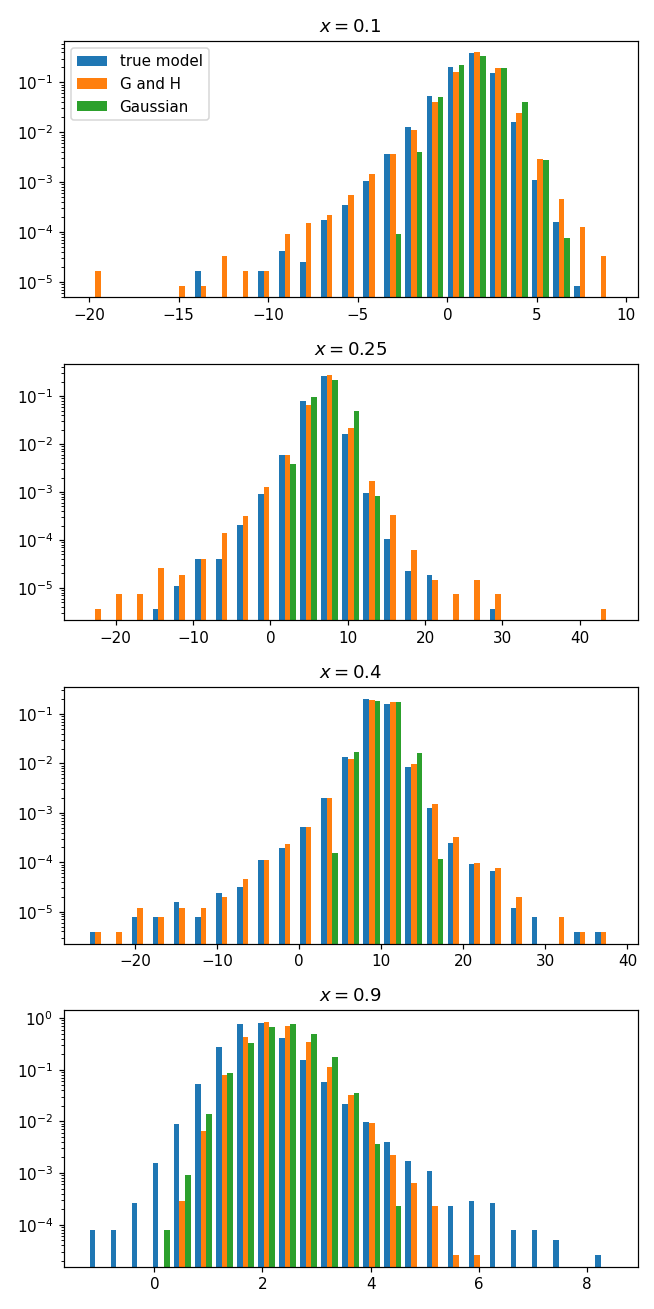

In [9]:
n_points = 100000
x_0s = [0.1, 0.25, 0.4, 0.9]
fig = plt.figure(figsize=(6, 12))


for i, x_0 in enumerate(x_0s):
    ax = fig.add_subplot(4, 1, i + 1)
    x = x_0 * np.ones(n_points, dtype=np.float32).reshape((-1, 1))
    z = np.random.randn(n_points).reshape((-1, 1))
    z2 = np.random.randn(n_points).reshape((-1, 1))


    theta_true = f(x)
    with torch.no_grad():
        theta_pred = loss.predict(nn(torch.tensor(x).reshape((-1, 1))))
        theta_gaussian_pred = loss_gaussian.predict(nn_gaussian(torch.tensor(x).reshape((-1, 1))))
    y_true = tukey_g_h(z, theta_true)
    #y_true = t_dist(x.reshape((1, -1))).reshape((-1, 1))

    y_pred = tukey_g_h(z, theta_pred)
    y_gaussian_pred = theta_gaussian_pred[0] + 1 / theta_gaussian_pred[1] * z

    ax.hist(np.hstack((y_true, y_pred, y_gaussian_pred)), 
            bins=25, density=True, cumulative=False, log=True,
            label=('true model', 'G and H', 'Gaussian'))
    ax.set_title(f'$x={x_0}$')
    if i == 0:
        plt.legend()
fig.tight_layout()

For a more rigurous analysis, we can compare the distribution of the $\hat{z}_i$'s to that of a standard normal.

In [10]:
import tukey.losses as ll

with torch.no_grad():
    theta_hat = loss.predict(nn(torch.from_numpy(x_data_val.reshape((-1, 1)))))
    mu, beta, g, h = theta_hat
    z_tilda = (torch.from_numpy(y_data_val.reshape((-1, 1))) - mu) * beta
    z_hat = ll.Tuckey_g_h_inverse.forward(None, z_tilda, g, h)

z_hat = z_hat.numpy()

<IPython.core.display.Javascript object>


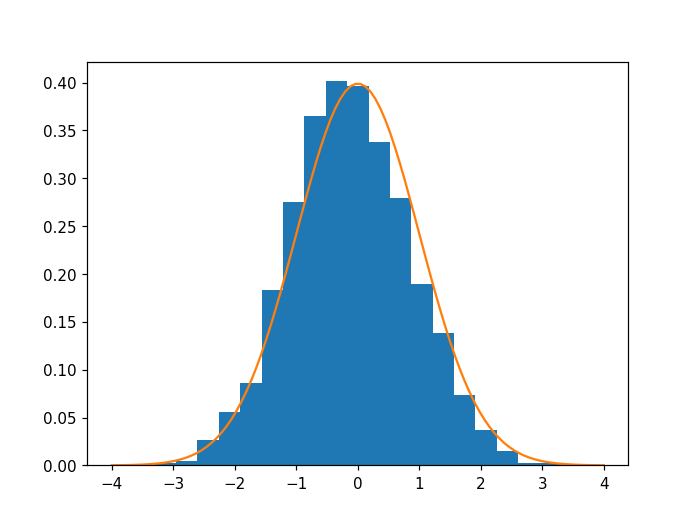

In [11]:
from scipy.stats import norm

plt.figure()
plt.hist(z_hat, bins=np.linspace(-4, 4, 24), density=True)
plt.plot(np.linspace(-4, 4, 100), norm.pdf(np.linspace(-4, 4, 100)))

We do a QQ plot to compare to the standard normal distribution.

<IPython.core.display.Javascript object>


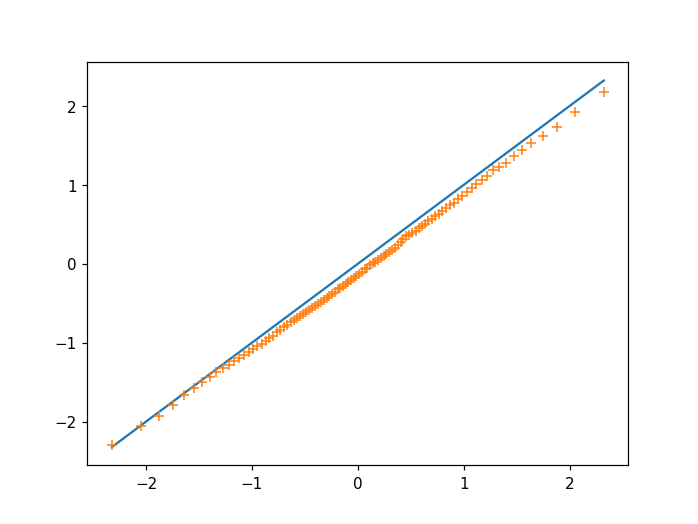

In [12]:
q = np.linspace(0, 1, 100)[1: -1]
true_quantiles = norm.ppf(q)
data_quantiles = np.quantile(z_hat, q)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(true_quantiles, true_quantiles)
ax.plot(true_quantiles, data_quantiles, '+')

## Prediction confidence intervals 

One can easily obtain prediction confidence intervals from the trained neural network (even though these are not as rigurous as prediction confidence intervals understood in statistical terms, where one also accounts for the uncertainty in the parameter estimates - here this would correspond to the uncertainty in the parameters of the neural network, which could be approached by Bayesian NN or Bootstrapping??).

In [13]:
confidence_level = 0.5
x_plot = np.linspace(min(x_data), max(x_data), 256).astype(np.float32).reshape((-1, 1))

<IPython.core.display.Javascript object>


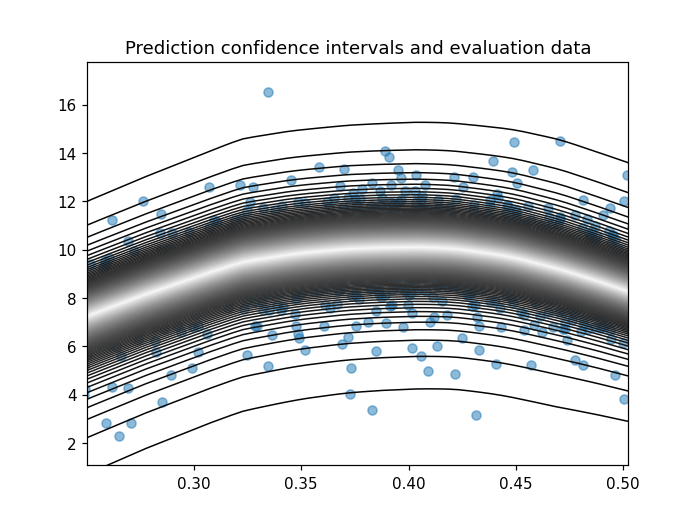

Text(0.5, 1.0, 'Prediction confidence intervals and evaluation data')

In [14]:
plt.figure()

for confidence_level in np.arange(0.01, 1, 0.01):
    with torch.no_grad():
        lb, ub = loss.predict_ci(nn(torch.from_numpy(x_plot)), confidence_level)
        lb = lb.numpy()
        ub = ub.numpy()
    color = (1 - confidence_level, ) * 3
    plt.plot(x_plot, lb, color=color, linewidth=1)
    plt.plot(x_plot, ub, color=color, linewidth=1)

plt.scatter(x_data_val, y_data_val, zorder=1, alpha=0.5)
plt.title('Prediction confidence intervals and evaluation data')

## Bootstrapping prediction confidence intervals 

Our prediction confidence intervals are not prediction confidence intervals in the usual statistical sense, as we do not account for the uncertainty in parameter estimates (here the parameters of the neural network).
One way we might approach this is via bootstrapping - we simulate new values using the fitted distributions, train the neural network on those new values.

In [15]:
import copy
n_boot = 10  # number of bootstrap neural networks
nn_boots = [] # list to keep references to bootstrap neural networks

for i_boot in range(n_boot):
    nn_boot = copy.deepcopy(nn)  # we start from the trained nn
    nn_boots.append(nn_boot)
    
    # simulate bootstrap data from the trained model
    nn.eval()
    with torch.no_grad():
        theta_hat = loss.predict(nn(torch.from_numpy(x_data).reshape((-1, 1))))
        theta_hat = [v.numpy() for v in theta_hat]
        y_data_boot = tukey_g_h(np.random.randn(*x_data.shape).reshape((-1, 1)), theta_hat)

    x_torch, y_torch = torch.tensor(x_data).reshape((-1, 1)), torch.tensor(y_data_boot).reshape((-1, 1))
    dataset_boot = TensorDataset(x_torch, y_torch)
    
    # train the bootstrap neural network on bootstrap data
    for i_epoch in range(20):
        optimizer = Adam(nn_boot.parameters(), lr=1e-4)
        epoch_loss = train_for_one_epoch(nn_boot, dataset_boot)

Train losses:  0.5947540561287828 0.7485224173438112
Validation losses:  0.5849468987435102 0.736826416105032
Train losses:  0.5919043249487472 0.7500434807867861
Validation losses:  0.5870291693136096 0.7178697064518929
Train losses:  0.5959292532853584 0.7479478184387234
Validation losses:  0.5686077503487468 0.7163335997611284
Train losses:  0.5940292680432978 0.7483695924841852
Validation losses:  0.5606258772313595 0.7004629299044609
Train losses:  0.5914968988046845 0.7458213580905289
Validation losses:  0.5635730428621173 0.7010687347501516
Train losses:  0.5921840526349385 0.7458014692595267
Validation losses:  0.5826956629753113 0.7271666433662176
Train losses:  0.5921488877397809 0.7470074528139593
Validation losses:  0.5704648401588202 0.7316670976579189
Train losses:  0.594432545879032 0.7498774514766458
Validation losses:  0.5621866127476096 0.7081470740959048
Train losses:  0.5934622873719254 0.7486909865350317
Validation losses:  0.5667008338496089 0.7125198859721422
Tra

Train losses:  0.6076568958113105 0.7925951824396141
Validation losses:  0.5703952116891742 0.7397072035819292
Train losses:  0.6030350952456045 0.7929597892846079
Validation losses:  0.5596072338521481 0.7324853334575891
Train losses:  0.6030263150000211 0.7876042254692494
Validation losses:  0.570627304725349 0.7362314984202385
Train losses:  0.6046171630552762 0.7913496640750324
Validation losses:  0.5840147519484162 0.7406938532367349
Train losses:  0.6040206478076257 0.7868371919647702
Validation losses:  0.5717939855530858 0.7378502301871777
Train losses:  0.6090734309367603 0.7627710417421384
Validation losses:  0.5727412300184369 0.7341570500284433
Train losses:  0.6093192397418729 0.7609845506991947
Validation losses:  0.5578244496136904 0.7424737857654691
Train losses:  0.6060334100127696 0.7579969695858326
Validation losses:  0.5632470101118088 0.7427695654332638
Train losses:  0.60543215075895 0.7572743731138545
Validation losses:  0.6028815293684602 0.7674099467694759
Trai

Train losses:  0.6010705695007633 0.7937703057735003
Validation losses:  0.5804636841639876 0.7142054243013263
Train losses:  0.6020193249721799 0.7890622569614228
Validation losses:  0.5840677926316857 0.7234856076538563
Train losses:  0.5999944118012943 0.7918667473454527
Validation losses:  0.5911520766094327 0.722714651376009
Train losses:  0.6001844990651141 0.789944539375712
Validation losses:  0.5859911981970072 0.7117351554334164
Train losses:  0.6004063438156093 0.7878239961176318
Validation losses:  0.5718861892819405 0.6992030795663595
Train losses:  0.5994895385906133 0.7862373288938288
Validation losses:  0.573022460564971 0.7225006651133299
Train losses:  0.5991542783236548 0.7937432316564393
Validation losses:  0.5749911768361926 0.7060842588543892
Train losses:  0.6017186071703845 0.790744950369422
Validation losses:  0.5597211783751845 0.6906523732468486
Train losses:  0.60190134504435 0.7892342235999312
Validation losses:  0.569147159345448 0.7055362015962601
Train lo

<IPython.core.display.Javascript object>


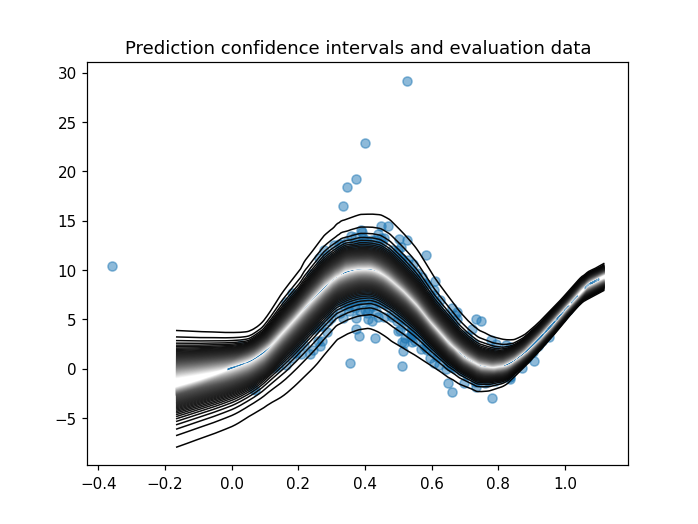

Text(0.5, 1.0, 'Prediction confidence intervals and evaluation data')

In [16]:
plt.figure()

for confidence_level in np.arange(0.01, 1, 0.01):
    lbs, ubs = [], []
    for nn_boot in nn_boots:
        with torch.no_grad():
            lb, ub = loss.predict_ci(nn_boot(torch.from_numpy(x_plot)), confidence_level)
            lb = lb.numpy()
            ub = ub.numpy()
        lbs.append(lb)
        ubs.append(ub)
    lbs = np.stack(lbs, axis=0)
    ubs = np.stack(ubs, axis=0)
    # currently we use the mean but incorrect
    lb = np.min(lbs, axis=0)
    ub = np.max(ubs, axis=0)
    color = (1 - confidence_level, ) * 3
    plt.plot(x_plot, lb, color=color, linewidth=1)
    plt.plot(x_plot, ub, color=color, linewidth=1)

plt.scatter(x_data_val, y_data_val, zorder=1, alpha=0.5)
plt.title('Prediction confidence intervals and evaluation data')

In [ ]:
lbs.shape

In [ ]:
ubs[:, 0, :]

Here we define a proper class to implement the bootstrapped prediction confidence intervals

In [ ]:
from torch.nn import Module

class Bootstrapped:
    def __init__(self, loss, trained_model: Module, n_bootstraps: int):
        self.loss = loss
        self.trained_model = trained_model
        self.n_bootstraps = n_bootstraps
        self.boot_models = []

    def generate_bootstrap_data(self, x_data: np.ndarray):
        """
        Generate bootstrap data using the passed features and the 
        conditional distributions corresponding to the trained neural
        network.
        """
        self.trained_model.eval()
        with torch.no_grad():
            x_data = torch.from_numpy(x_data).reshape((-1, 1))
            theta_hat = loss.predict(self.trained_model(x_data))
            theta_hat = [v.numpy() for v in theta_hat]
        y_data_boot = tukey_g_h(np.random.randn(*x_data.shape).reshape((-1, 1)), theta_hat)

        x_torch, y_torch = torch.tensor(x_data).reshape((-1, 1)), torch.tensor(y_data_boot).reshape((-1, 1))
        dataset_boot = TensorDataset(x_torch, y_torch)
        return dataset_boot
    
    def train(self, x: np.ndarray):
        """
        Train the bootstrap neural networks on bootstrap data from
        the trained model.
        """
        for i_boot in range(self.n_bootstraps):
            nn_boot = copy.deepcopy(self.trained_model)  # we start from the trained nn
            self.boot_models.append(nn_boot)

            # simulate bootstrap data from the trained model
            dataset_boot = self.generate_bootstrap_data(x)

            # train the bootstrap neural network on bootstrap data
            for i_epoch in range(20):
                optimizer = Adam(nn_boot.parameters(), lr=1e-4)
                epoch_loss = train_for_one_epoch(nn_boot, dataset_boot)
        
    def cumulative(self, x, y):
        """
        Provide the cumulative distribution function of predictions
        based on the bootstrapped neural networks.
        """
        raise NotImplementedError()

    def confidence_interval(self, x, level: float):
        """
        Provide prediction confidence intervals.
        """
        